In [ ]:
library(Seurat)
library(repr)
library(readxl)
library(writexl)
library(tidyverse)
library(miloR)
library(SingleCellExperiment)
library(scater)
library(scran)
library(patchwork)

# Defining experimental design

In [ ]:
npvalue=read_xlsx("/data2/xiangwei/projects/zhaolian_old/BfinalSample/Np_new2.xlsx")%>% select(sampleID,Np,`1/Np`) %>% 
mutate(stage=if_else(Np>3,"early_stage","late_stage"))%>%as.data.frame()

In [3]:
npvalue

sampleID,Np,1/Np,stage
<chr>,<dbl>,<dbl>,<chr>
148_T1,1.604244,0.62334657,late_stage
148_T3,2.670790,0.37442101,late_stage
142_T5-4,2.802020,0.35688537,late_stage
132_T1,4.075022,0.24539743,early_stage
142_T2,5.653750,0.17687375,early_stage
18_T3,6.088663,0.16423968,early_stage
18_T4,9.575361,0.10443470,early_stage
17_T4,11.891945,0.08409053,early_stage
151_T4,32.589013,0.03068519,early_stage


In [4]:
wt=tribble(~sampleID,~Np,~`1/Np`,~stage,
         "WT1",100,0.01,"early_stage",
         "WT2",100,0.01,"early_stage")

In [5]:
npvalue=rbind(npvalue,wt)

In [6]:
studyDesign=npvalue
rownames(studyDesign)=studyDesign$sampleID
studyDesign

,sampleID,Np,1/Np,stage
,<chr>,<dbl>,<dbl>,<chr>
148_T1,148_T1,1.604244,0.62334657,late_stage
148_T3,148_T3,2.670790,0.37442101,late_stage
142_T5-4,142_T5-4,2.802020,0.35688537,late_stage
132_T1,132_T1,4.075022,0.24539743,early_stage
142_T2,142_T2,5.653750,0.17687375,early_stage
18_T3,18_T3,6.088663,0.16423968,early_stage
18_T4,18_T4,9.575361,0.10443470,early_stage
17_T4,17_T4,11.891945,0.08409053,early_stage
151_T4,151_T4,32.589013,0.03068519,early_stage


In [ ]:
rownames(studyDesign)

# load anntation data

In [8]:
scdata=readRDS("/data2/xiangwei/projects/zhaolian/10polyIntegrate/results/sctAnnotationSeuObj")

In [9]:
scdata$sampleID=as.character(scdata$sampleID)
table(scdata$sampleID)


  132_T1   142_T2 142_T5-4   148_T1   148_T3   151_T4    17_T4    18_T3 
    4387     4389     4879     5110     3812     5141     7870     5304 
   18_T4      WT1      WT2 
    2109     1387     1232 

In [10]:
cellID=colnames(scdata)

# add metadata

In [11]:
scdata@meta.data=scdata@meta.data%>%left_join(studyDesign,by = "sampleID")

In [12]:
rownames(scdata@meta.data)=cellID

In [13]:
scdata$sampleID=factor(scdata$sampleID,levels = c('148_T1','148_T3','142_T5-4','132_T1',
                                                    '142_T2','18_T3','18_T4','17_T4','151_T4',
                                                  'WT1','WT2'))

In [14]:
head(scdata@meta.data)

,nCount_RNA,nFeature_RNA,sampleID,percent.mt,Phase,sampleType,sampleTypeFine,nCount_SCT,nFeature_SCT,unintegrated_clusters,seurat_clusters,cca_cluster,rpca_cluster,harmony_cluster,main,fine,Np,1/Np,stage
,<dbl>,<dbl>,<fct>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<chr>
WT_1.bcHTXJ,5633,2155,WT1,3.586011,G1,normal,WT1,2575,1386,8,10,16,10,10,Epithelial,Epi-Krt20,100,0.01,early_stage
WT_1.bcHGRE,10487,3855,WT1,5.912082,G2M,normal,WT1,2180,1408,8,11,0,9,11,Epithelial,Epi-Srgn,100,0.01,early_stage
WT_1.bcHIFA,9429,3137,WT1,6.352742,G2M,normal,WT1,2197,1152,8,10,16,10,10,Epithelial,Epi-Krt20,100,0.01,early_stage
WT_1.bcHFJN,7902,2746,WT1,7.884080,G1,normal,WT1,2205,1178,8,10,16,10,10,Epithelial,Epi-Krt20,100,0.01,early_stage
WT_1.bcGOTP,7605,3330,WT1,4.865220,S,normal,WT1,2136,1383,20,0,11,22,0,Neutrophil,Neutrophil,100,0.01,early_stage
WT_1.bcFBTL,8837,2901,WT1,6.551997,G1,normal,WT1,2213,1189,8,10,3,10,10,Epithelial,Epi-Krt20,100,0.01,early_stage


# Create a Milo object from Seurat object

In [15]:
DefaultAssay(scdata)="SCT"

In [16]:
table(scdata$sampleID)


  148_T1   148_T3 142_T5-4   132_T1   142_T2    18_T3    18_T4    17_T4 
    5110     3812     4879     4387     4389     5304     2109     7870 
  151_T4      WT1      WT2 
    5141     1387     1232 

In [17]:
scdataV3=scdata

In [ ]:
# convert a v5 assay to a v3 assay
scdataV3[["RNA"]] <- as(object = scdata[["RNA"]], Class = "Assay")

In [19]:
scdata_sc=as.SingleCellExperiment(scdataV3)

In [20]:
scdata_sc

class: SingleCellExperiment 
dim: 22704 45620 
metadata(0):
assays(2): counts logcounts
rownames(22704): 0610009B22Rik 0610009E02Rik ... Olfml1 Rhox5
rowData names(0):
colnames(45620): WT_1.bcHTXJ WT_1.bcHGRE ... 148T3_TTTGTCAGTGGGTATG-1
  148T3_TTTGTCATCGCAGGCT-1
colData names(20): nCount_RNA nFeature_RNA ... stage ident
reducedDimNames(8): PCA UMAP.UNINTEGRATED ... UMAP.RPCA UMAP.HARMONY
mainExpName: SCT
altExpNames(1): RNA

In [21]:
scdata_milo = Milo(scdata_sc)

In [22]:
scdata_milo

class: Milo 
dim: 22704 45620 
metadata(0):
assays(2): counts logcounts
rownames(22704): 0610009B22Rik 0610009E02Rik ... Olfml1 Rhox5
rowData names(0):
colnames(45620): WT_1.bcHTXJ WT_1.bcHGRE ... 148T3_TTTGTCAGTGGGTATG-1
  148T3_TTTGTCATCGCAGGCT-1
colData names(20): nCount_RNA nFeature_RNA ... stage ident
reducedDimNames(8): PCA UMAP.UNINTEGRATED ... UMAP.RPCA UMAP.HARMONY
mainExpName: SCT
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(0):
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1

In [ ]:
saveRDS(scdata_milo,"results/scdata_milo")

In [ ]:
scdata_milo=readRDS("results/scdata_milo")

In [ ]:
#plotUMAP(scdata_milo)

# Construct KNN graph

In [23]:
scdata_milo = buildGraph(scdata_milo, k = 30, d = 50,reduced.dim = "INTEGRATED.HARMONY")

Constructing kNN graph with k:30



# Defining representative neighbourhoods on the KNN graph

In [24]:
scdata_milo = makeNhoods(scdata_milo, prop = 0.1, k = 30, d=50, refined = TRUE, reduced_dims  = "INTEGRATED.HARMONY")

Checking valid object

Running refined sampling with reduced_dim



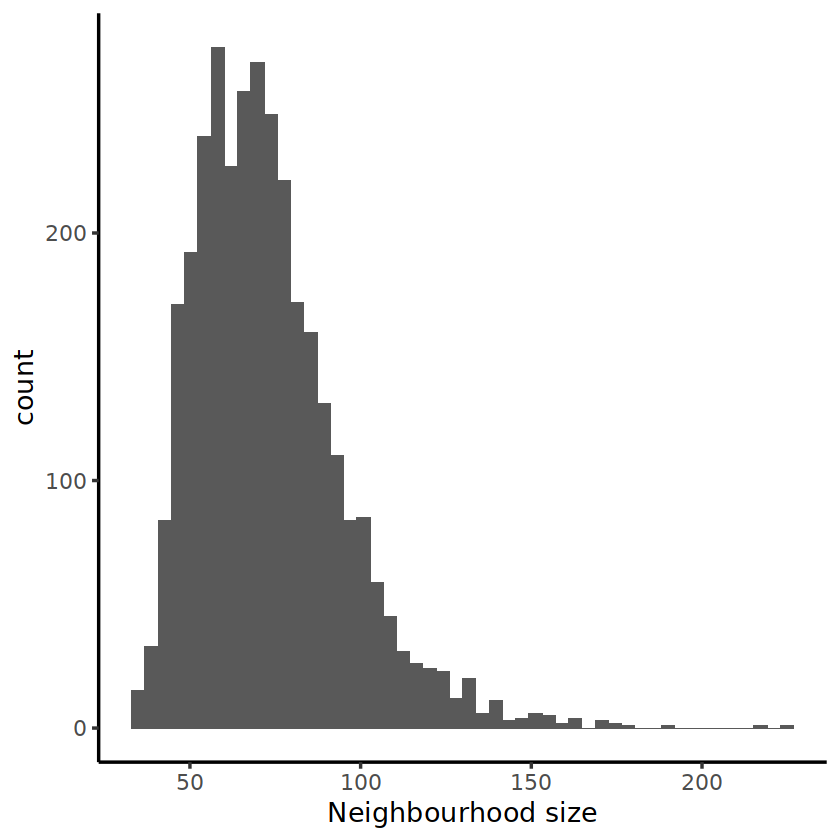

In [25]:
plotNhoodSizeHist(scdata_milo)

# Counting cells in neighbourhoods

In [26]:
scdata_milo = countCells(scdata_milo, meta.data = as.data.frame(colData(scdata_milo)), sample="sampleID")

Checking meta.data validity

Counting cells in neighbourhoods



In [27]:
head(nhoodCounts(scdata_milo))
dim(nhoodCounts(scdata_milo))

  [[ suppressing 11 column names ‘148_T1’, ‘148_T3’, ‘142_T5-4’ ... ]]



6 x 11 sparse Matrix of class "dgCMatrix"
                                
1  9 10 15 10 16  2  3 13  5 . .
2 32 11 10  7 11  .  1  3  . . .
3  .  3  .  2 19  8  3  2 11 . .
4  1  1  1 10  2 11 22 26 13 . .
5 73  1 13  1  .  .  .  9  . . .
6 26  9  7  . 11  1  .  2  2 . .

[1] 3263   11

## Computing neighbourhood connectivity

In [28]:
scdata_milo = calcNhoodDistance(scdata_milo, d=50,reduced.dim ="INTEGRATED.HARMONY")

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



## Testing

In [29]:
studyDesign

,sampleID,Np,1/Np,stage
,<chr>,<dbl>,<dbl>,<chr>
148_T1,148_T1,1.604244,0.62334657,late_stage
148_T3,148_T3,2.670790,0.37442101,late_stage
142_T5-4,142_T5-4,2.802020,0.35688537,late_stage
132_T1,132_T1,4.075022,0.24539743,early_stage
142_T2,142_T2,5.653750,0.17687375,early_stage
18_T3,18_T3,6.088663,0.16423968,early_stage
18_T4,18_T4,9.575361,0.10443470,early_stage
17_T4,17_T4,11.891945,0.08409053,early_stage
151_T4,151_T4,32.589013,0.03068519,early_stage


## stage

In [30]:
stage_results = testNhoods(scdata_milo, design = ~ stage, design.df = studyDesign)

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



In [31]:
head(stage_results)
dim(stage_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.137043,8.988441,0.5692319,0.450570341,0.7085354,1,0.6875084
2,2.753500,8.927113,3.5662150,0.058976419,0.3553926,2,0.2973411
3,-2.078706,8.351989,1.3678155,0.242197062,0.5458937,3,0.5142931
4,-3.065549,9.010485,2.4464146,0.117804430,0.4194085,4,0.3777231
5,4.783199,9.180979,9.6894714,0.001855048,0.2080004,5,0.1162178
6,2.959816,8.619529,4.3703728,0.036577567,0.3269934,6,0.2651479


[1] 3263    7

## 1/Np

In [32]:
Np1_results = testNhoods(scdata_milo, design = ~ `1/Np`, design.df = studyDesign)

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



In [33]:
head(Np1_results)
dim(Np1_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5.190406,8.988341,1.262476,0.2611920698,0.51872777,1,0.50533808
2,11.084301,8.926931,7.072159,0.0078333324,0.11120797,2,0.08242467
3,-4.154925,8.351980,0.519893,0.4708930629,0.71741779,3,0.69900121
4,-5.780101,9.010350,1.311359,0.2521580353,0.50893512,4,0.49524657
5,10.761152,9.180921,11.722684,0.0006182712,0.04812558,5,0.02633883
6,9.191886,8.619381,6.273961,0.0122578679,0.12151392,6,0.09399981


[1] 3263    7

## Inspecting DA testing results

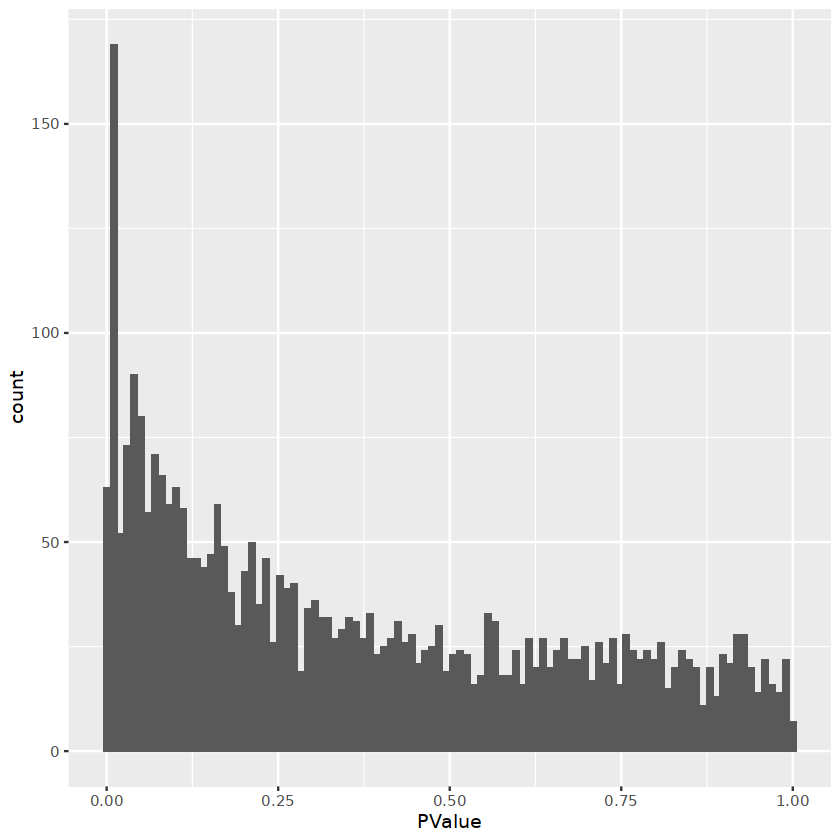

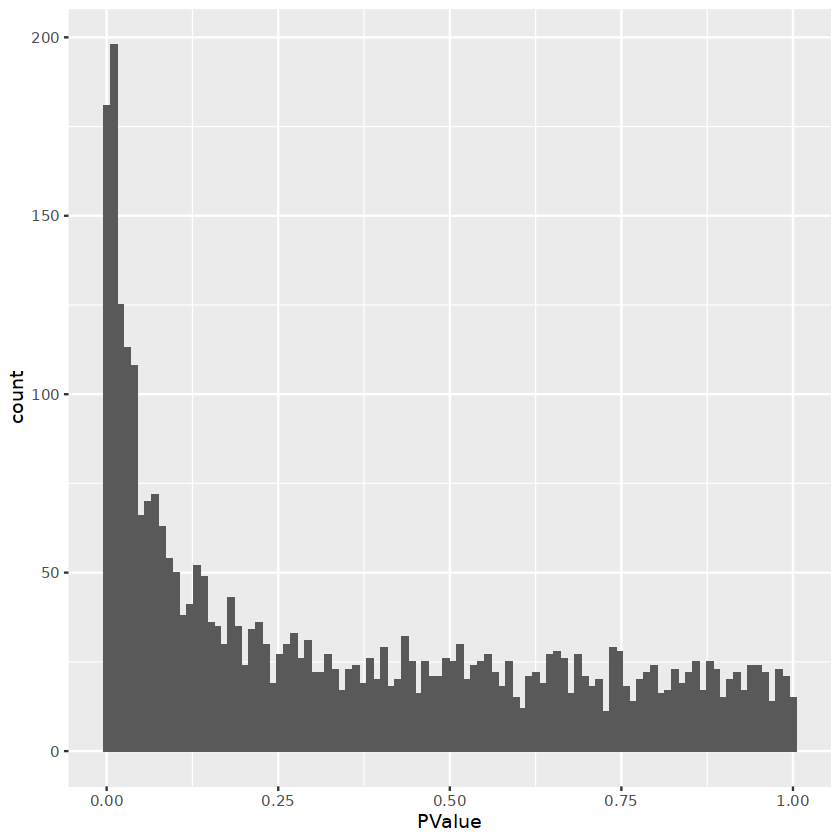

In [34]:
options(repr.plot.width=7)
ggplot(stage_results, aes(PValue)) + geom_histogram(bins=100)
ggplot(Np1_results, aes(PValue)) + geom_histogram(bins=100)

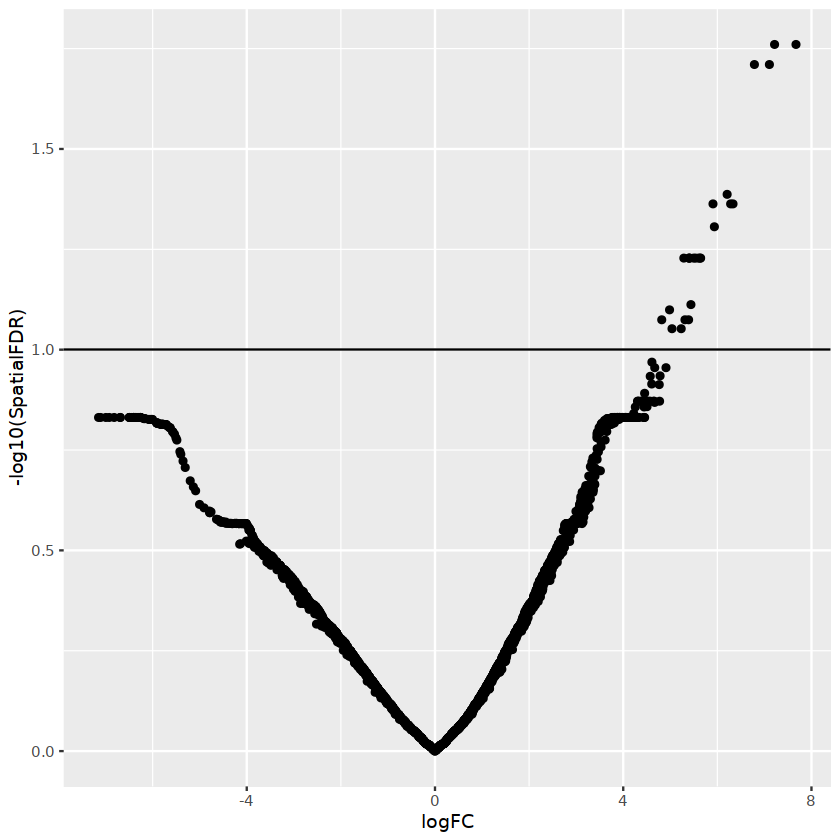

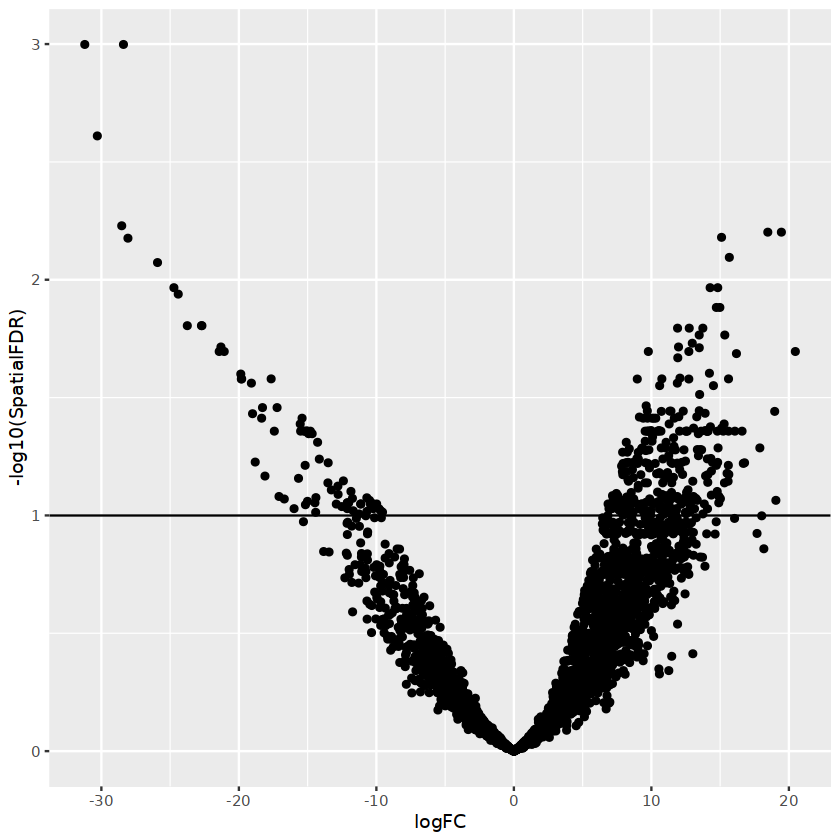

In [35]:
ggplot(stage_results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = 1)

ggplot(Np1_results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = 1)

# visualize DA results

In [36]:
scdata_milo = buildNhoodGraph(scdata_milo)

In [ ]:
## stage
options(repr.plot.width=14)
umap_pl = plotReducedDim(scdata_milo, dimred = "UMAP.HARMONY", colour_by="fine", text_by = "fine", 
                          text_size = 3, point_size=0.5) + guides(fill="none")

nh_graph_pl = plotNhoodGraphDA(scdata_milo, stage_results,layout="UMAP.HARMONY",alpha=0.1) 

umap_pl + nh_graph_pl + plot_layout(guides="collect")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


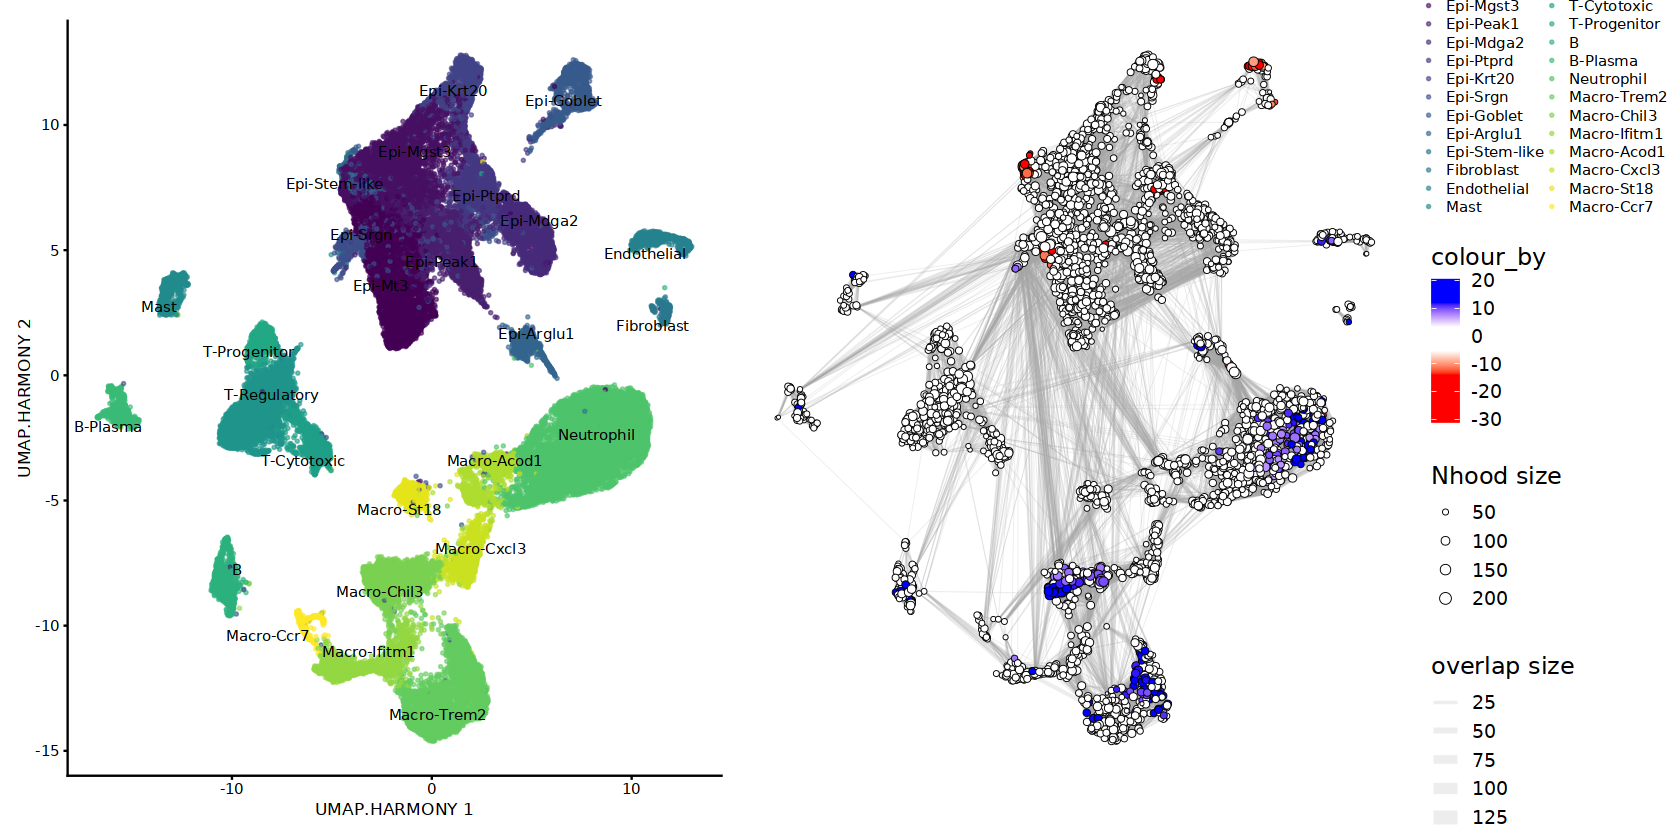

In [38]:
## 1/Np
options(repr.plot.width=14)
umap_pl = plotReducedDim(scdata_milo, dimred = "UMAP.HARMONY", colour_by="fine", text_by = "fine", 
                          text_size = 3, point_size=0.5) + guides(fill="none")

nh_graph_pl = plotNhoodGraphDA(scdata_milo, Np1_results,layout="UMAP.HARMONY",alpha=0.1)+
scale_fill_gradientn(colours = c("red", "red","red","white","white","blue", "blue"))
#scale_fill_gradient2(low = "red",  high = "blue")

umap_pl + nh_graph_pl + plot_layout(guides="collect")

In [ ]:
ggsave(nh_graph_pl,filename = "results/plot/UMAPmiloR.pdf",width = 8,height = 6)

In [39]:
stage_results = annotateNhoods(scdata_milo, stage_results, coldata_col = "fine")
Np1_results = annotateNhoods(scdata_milo, Np1_results, coldata_col = "fine")
head(stage_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine,fine_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,1.137043,8.988441,0.5692319,0.450570341,0.7085354,1,0.6875084,T-Regulatory,1.0000000
2,2.753500,8.927113,3.5662150,0.058976419,0.3553926,2,0.2973411,Macro-Trem2,1.0000000
3,-2.078706,8.351989,1.3678155,0.242197062,0.5458937,3,0.5142931,Epi-Mt3,0.9791667
4,-3.065549,9.010485,2.4464146,0.117804430,0.4194085,4,0.3777231,Epi-Peak1,1.0000000
5,4.783199,9.180979,9.6894714,0.001855048,0.2080004,5,0.1162178,Neutrophil,1.0000000
6,2.959816,8.619529,4.3703728,0.036577567,0.3269934,6,0.2651479,Endothelial,1.0000000


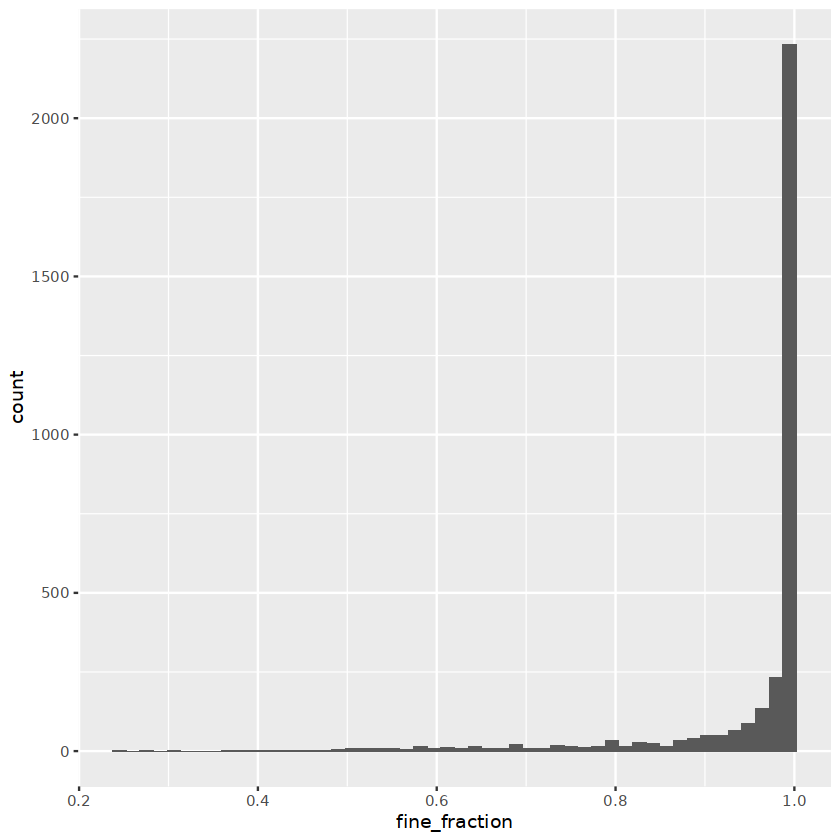

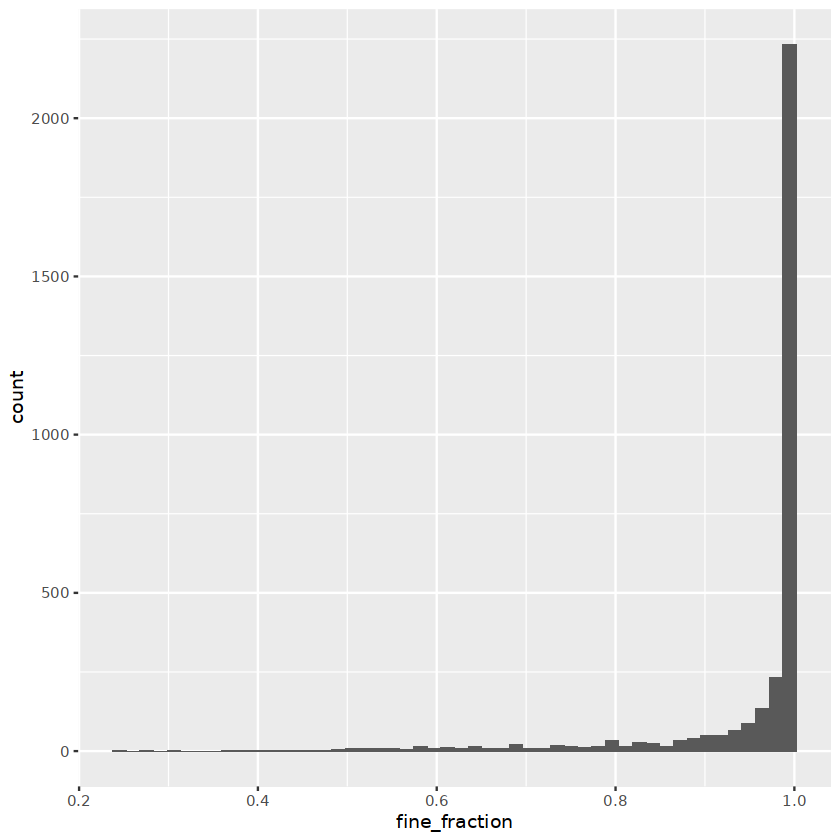

In [40]:
options(repr.plot.width=7)
ggplot(stage_results, aes(fine_fraction)) + geom_histogram(bins=50)
ggplot(Np1_results, aes(fine_fraction)) + geom_histogram(bins=50)

In [41]:
stage_results$fine <- ifelse(stage_results$fine_fraction < 0.7, "Mixed", stage_results$fine)
Np1_results$fine <- ifelse(Np1_results$fine_fraction < 0.7, "Mixed", Np1_results$fine)

In [42]:
head(stage_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine,fine_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,1.137043,8.988441,0.5692319,0.450570341,0.7085354,1,0.6875084,T-Regulatory,1.0000000
2,2.753500,8.927113,3.5662150,0.058976419,0.3553926,2,0.2973411,Macro-Trem2,1.0000000
3,-2.078706,8.351989,1.3678155,0.242197062,0.5458937,3,0.5142931,Epi-Mt3,0.9791667
4,-3.065549,9.010485,2.4464146,0.117804430,0.4194085,4,0.3777231,Epi-Peak1,1.0000000
5,4.783199,9.180979,9.6894714,0.001855048,0.2080004,5,0.1162178,Neutrophil,1.0000000
6,2.959816,8.619529,4.3703728,0.036577567,0.3269934,6,0.2651479,Endothelial,1.0000000


In [ ]:
names(table(stage_results$fine))
names(table(Np1_results$fine))

In [ ]:
stage_results$fine=factor(stage_results$fine,levels=c(
'Epi-Mt3','Epi-Mgst3','Epi-Peak1','Epi-Mdga2','Epi-Ptprd','Epi-Saa1','Epi-Srgn','Epi-Goblet','Epi-Camk1d','Epi-Stemness',
'Fibroblast',
'Endothelial',
'Mast',
'T-Regulatory','T-Cytotoxic','T-Progenitor',
'B','B-Plasma',
'Neutrophil',
'Macro-Trem2','Macro-Chil3','Macro-Ifitm1','Macro-Acod1','Macro-Cxcl3','Macro-St18','Macro-Ccr7',
'Mixed'
))

In [44]:
Np1_results$fine=factor(Np1_results$fine,levels=rev(c(
'Epi-Mt3','Epi-Mgst3','Epi-Peak1','Epi-Mdga2','Epi-Ptprd','Epi-Krt20','Epi-Srgn','Epi-Goblet','Epi-Arglu1','Epi-Stem-like',
'Fibroblast',
'Endothelial',
'Mast',
'T-Regulatory','T-Cytotoxic','T-Progenitor',
'B','B-Plasma',
'Neutrophil',
'Macro-Trem2','Macro-Chil3','Macro-Ifitm1','Macro-Acod1','Macro-Cxcl3','Macro-St18','Macro-Ccr7',
'Mixed'
)))

In [ ]:
## stage
options(repr.plot.width=7)
plotDAbeeswarm(stage_results, group.by = "fine",alpha = 0.1)

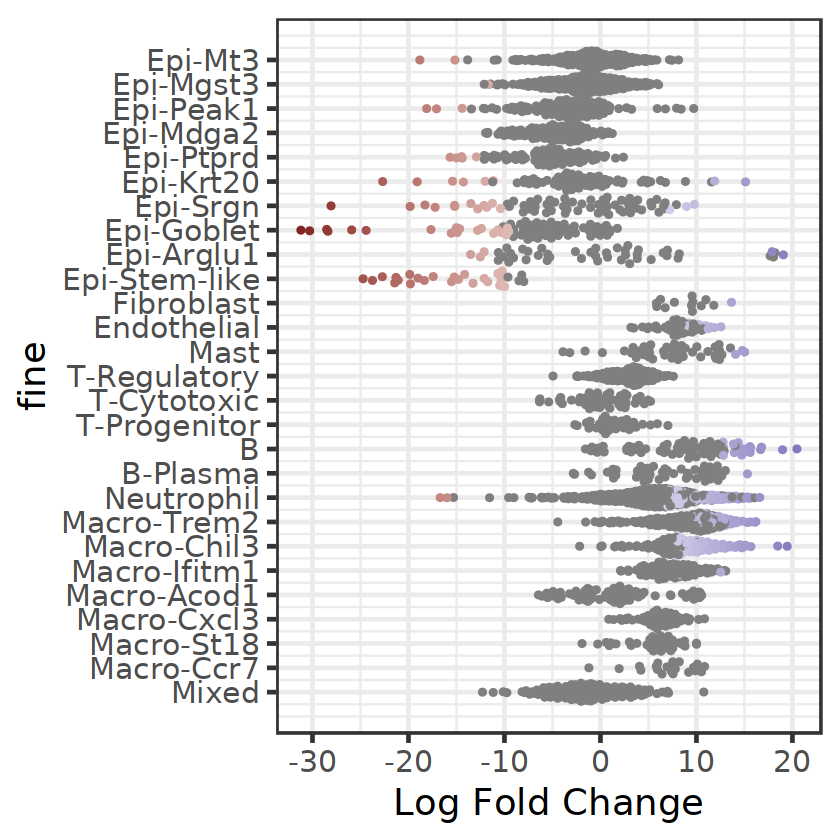

In [45]:
## 1/Np
options(repr.plot.width=7)
dotplotMiloR=plotDAbeeswarm(Np1_results, group.by = "fine",alpha = 0.1)
dotplotMiloR

In [46]:
ggsave(dotplotMiloR,filename = "results/plot/dotplotMiloR.pdf",height = 10,width = 8)